# Consumer

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
import time

appName = "Twitter Real-time Analytics via Kafka and Spark"
master = "local"
conf = pyspark.SparkConf().set('spark.driver.host','127.0.0.1').setAppName(appName).setMaster(master)
sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession.builder \
    .appName("Twitter Spark and Kafka example") \
        .getOrCreate()

sc

<SparkContext master=local appName=Twitter Real-time Analytics via Kafka and Spark>

In [3]:
from kafka import KafkaConsumer
import json

topic_name = 'testing'

kafka_consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='latest',
    enable_auto_commit=True,
    auto_commit_interval_ms = 5000,
    fetch_max_bytes = 128,
    max_poll_records = 100,
    value_deserializer=lambda x: x.decode('utf-8'))

In [4]:
import tweepy
from pyspark.sql.functions import *
from pyspark.sql.types import *

streamed_data = None

wordlist = []
duration = 300 # seconds

start = time.time ()

for message in kafka_consumer:
    
    data = [message.value] 
    tweet = spark.createDataFrame(data,"string")
    
    if streamed_data is None:
        streamed_data = tweet.withColumn('word', explode(split(col('value'), ' '))) \
                    .groupBy('word') \
                    .count() \
                    .sort('count', ascending=False)
                    
        print ("First tweet received.")
        
    else:
        streamed_data = streamed_data.union(tweet.withColumn('word', explode(split(col('value'), ' '))) \
                    .groupBy('word') \
                    .count() \
                    .sort('count', ascending=False))
                    

    stream_time = time.time()-start
    if stream_time > duration:
        print (f"{streamed_data.count()} words stored.")
        break

streamed_data.show ()

First tweet received.
636 words stored.
+--------------------+-----+
|                word|count|
+--------------------+-----+
|               Trump|    1|
|          #Trump2024|    1|
|                  is|    1|
|              Donald|    1|
|                 the|    1|
|           president|    1|
|          legitimate|    1|
|                   a|    3|
|                  of|    2|
|              flower|    1|
|                 joy|    1|
|             opening|    1|
|memories...\n\n#f...|    1|
|              reader|    1|
|            bringing|    1|
|                 old|    1|
|             finding|    1|
|               dried|    1|
|               flood|    1|
|           forgotten|    1|
+--------------------+-----+
only showing top 20 rows



In [ ]:
search_terms = ['slowite','bruteforce','flood','malformed',"'DOS'",'legitimate']
sum_list = []

for i in range (len (search_terms)):
    word_count = streamed_data.filter (col('word').contains(search_terms[i]))
    word_count.show ()
    
    sum_count = word_count.select(sum('count')).collect()[0][0]
    if sum_count == None:
        sum_count=0
        sum_list.append (sum_count)
    else:
        sum_list.append (sum_count)
        
        
df = pd.DataFrame({
    'words': search_terms,
    'counts': sum_list
    })

In [5]:
search_terms = ['slowite','bruteforce','flood','malformed',"'DOS'",'legitimate']
sum_list = []

for i in range (len (search_terms)):
    word_count = streamed_data.filter (col('word').contains(search_terms[i]))
    word_count.show ()
    
    sum_count = word_count.select(sum('count')).collect()[0][0]
    if sum_count == None:
        sum_count=0
        sum_list.append (sum_count)
    else:
        sum_list.append (sum_count)
        
        
df = pd.DataFrame({
    'words': search_terms,
    'counts': sum_list
    })

+----+-----+
|word|count|
+----+-----+
+----+-----+

+----+-----+
|word|count|
+----+-----+
+----+-----+

+---------+-----+
|     word|count|
+---------+-----+
|    flood|    1|
|    flood|    1|
| flooding|    1|
|    flood|    1|
|megaflood|    1|
|    flood|    1|
|    flood|    1|
|  floods.|    1|
|    flood|    1|
|    flood|    1|
|    flood|    1|
|flood-hit|    1|
|    flood|    1|
|    flood|    1|
|    flood|    1|
+---------+-----+

+---------+-----+
|     word|count|
+---------+-----+
|malformed|    1|
+---------+-----+

+----+-----+
|word|count|
+----+-----+
+----+-----+

+-----------+-----+
|       word|count|
+-----------+-----+
| legitimate|    1|
|legitimate.|    1|
| legitimate|    1|
| legitimate|    1|
| legitimate|    1|
+-----------+-----+



In [6]:
data = {'words': search_terms, 'counts': sum_list}

df = pd.DataFrame(data).sort_values('counts', ascending=False)
df

,words,counts
2,flood,15
5,legitimate,5
3,malformed,1
0,slowite,0
1,bruteforce,0
4,'DOS',0


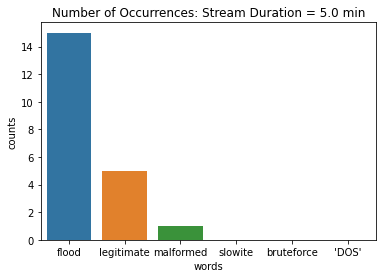

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

plt.figure( figsize = (6,4))
sns.barplot( x="words", y="counts", data=df)
plt.title (f'Number of Occurrences: Stream Duration = {duration/60} min')
plt.show()

The word **"flood"** was the most frequent term in 5-min Twitter feed.